In [11]:
import numpy as np
import pyccl as ccl

import matplotlib.pyplot as plt

import scipy.stats.qmc as qmc
import scipy.stats as stats
from scipy.interpolate import interp1d

from tqdm import trange, tqdm
from time import time
from multiprocessing import Pool, cpu_count
from parallelbar import progress_starmap

import src.datamaker as datamaker

from importlib import reload
reload(datamaker)

<module 'src.datamaker' from '/home/b7009348/CosyMAML/src/datamaker.py'>

In [17]:
n_tasks = 50
n_samples = 128

np.random.seed(14)
gridsize = 50

task_means = np.random.uniform(0.8, 1.6, n_tasks)
task_vars = np.random.uniform(0.2, 0.6, n_tasks)

survey_pz1 = np.empty((n_tasks, gridsize-1))
survey_pz2 = np.empty((n_tasks, gridsize-1))

for i in range(n_tasks): 
    # generate 2 random non overlapping grids representing redshift bins
    z1_min = np.random.uniform(0.2, 1.2)
    z2_min = np.random.uniform(1.2, 2.2)

    z1_max = np.random.uniform(z1_min+0.2, 1.6)
    z2_max = np.random.uniform(z2_min+0.2, 2.2)

    survey_pz1[i], survey_midpoints = datamaker.gen_Pz_base(
        task_means[i],
        task_vars[i],
        grid = np.linspace(z1_min, z1_max, gridsize)
    )

    survey_pz2[i], survey_midpoints = datamaker.gen_Pz_base(
        task_means[i],
        task_vars[i],
        grid = np.linspace(z2_min, z2_max, gridsize)
    )

true_means_z1 = np.empty(n_tasks)
true_means_z2 = np.empty(n_tasks)
shifts_z1 = np.empty((n_tasks, n_samples))
shifts_z2 = np.empty((n_tasks, n_samples))
qrd_pz1 = np.empty((n_tasks, n_samples, gridsize-1))
qrd_pz2 = np.empty((n_tasks, n_samples, gridsize-1))
for i in trange(n_tasks):
    qrd_pz1[i], true_means_z1[i] = datamaker.gen_Pz_samples(
                                        survey_pz1[i],
                                        survey_midpoints,
                                        seed=14,
                                        shift=0.01,
                                        qrd_samples=n_samples
                                    )
    
    qrd_pz2[i], true_means_z2[i] = datamaker.gen_Pz_samples(
                                        survey_pz2[i],
                                        survey_midpoints,
                                        seed=14,
                                        shift=0.01,
                                        qrd_samples=n_samples
                                    )
    
    for j in range(n_samples):
        mean = np.trapz(qrd_pz1[i, j]*survey_midpoints, survey_midpoints)
        shifts_z1[i, j] = mean - true_means_z1[i]

        mean = np.trapz(qrd_pz2[i, j]*survey_midpoints, survey_midpoints)
        shifts_z2[i, j] = mean - true_means_z2[i]

100%|██████████| 50/50 [04:17<00:00,  5.14s/it]


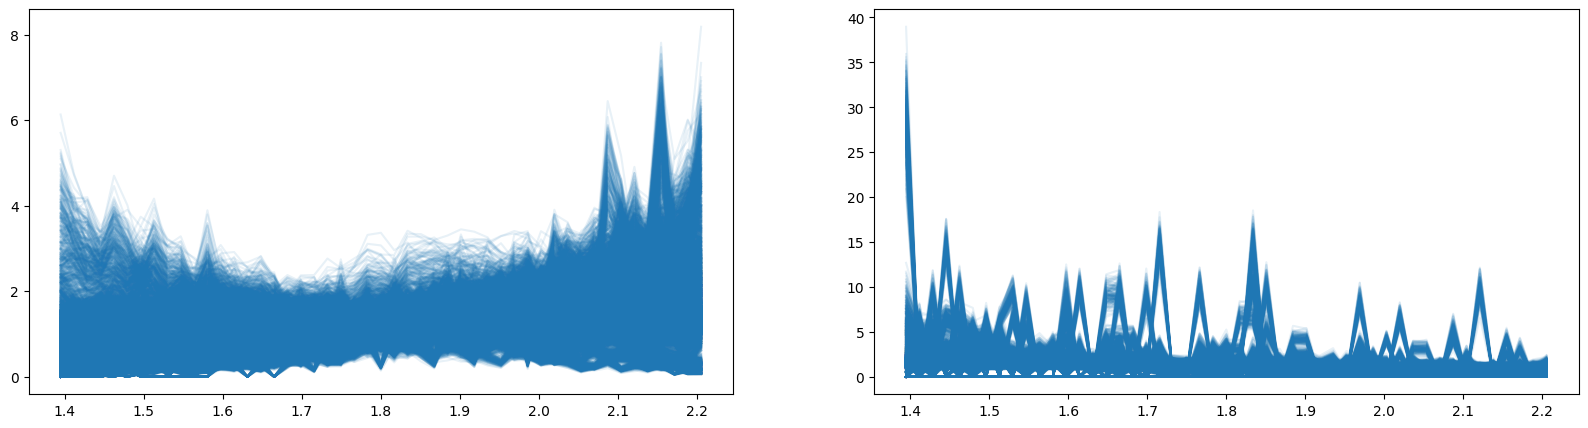

In [19]:
# Plot the generated P(z) samples
fig, ax = plt.subplots(1,2,figsize=(20,5))

for i in range(n_tasks):
    for j in range(n_samples):
        ax[0].plot(survey_midpoints, qrd_pz1[i,j], alpha=0.1, color='C0')
        ax[1].plot(survey_midpoints, qrd_pz2[i,j], alpha=0.1, color='C0')
